## Random Forest for Classification from Scratch
***



## Prerequisites

- Ensemble learning: Random forest is only a subset of this vast set of machine learning technique, you will better understand this assignment if you have a basic knowledge of this.

- numpy and pandas library: A good carpenter must be well versed with his tools. These two libraries are our tools.

The Algorithm of random forest is shown below.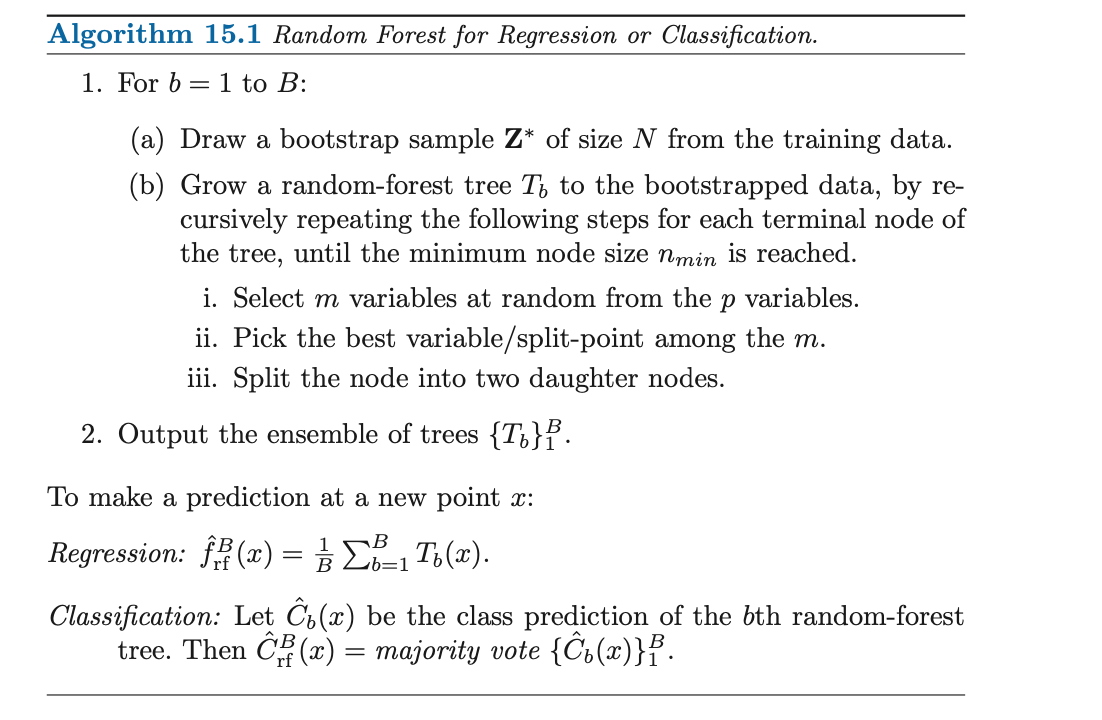

## A short essay



1.   Comparison on Decision Tree method, and Random Forest for classification task.

> The decision Tree method constructs only one decision tree, each node within the tree contains a splitting criterion that consists of a feature and a split point, which are determined by comparing the costs of all features.
To train the model, we store all observations of the training set to the root node. These observations will be binary split by splitting criterion and assigned into two child nodes.
Then calculate the cost to identify the optimal criterion in each node and binary split the data recursively.
The node will stop splitting when its cost function is high in both splitting criteria, or contains fewer instances than hyperparameter. The ending nodes of splitting are leaf nodes.
For prediction by decision tree, test set or observations will go through the tree, assigned to the appropriate child node by splitting criterion until leaf nodes. The prediction = majority of labels Y `Y_train` which are allocated to that particular leaf node.

> The random forest consists of several classification trees.  Each tree varies and is trained by unique bootstrap sample as input, which is randomly selected from the training set with replacement. Then, instead of all variables, only randomly selected features without replacement in each node are compared when determining the splitting criteria, and the best criterion among them will be chosen. last but not least, the final prediction is the majority vote of the predictions of all trees in random forest. Although the random forest method takes longer and has less interpretability than the decision tree method, it helps avoid overfitting by incorporating different predictions from various trees.




2.   Illustration on how to implement random forest with the help of python class DecisionTree.

> RandomForest using for-loop to generate several random selected DecisionTree. the class `DecisionTree()` needs to be modified and plugged in some hyperparameters as criteria to control and obtain the accuracy of random DecisionTrees training.  

> 1. To save the indices of the bootstraped sample, we add `idxs` as attribute `self.idxs` in `fit()`, each node will renew data indices by selected sample `idxs`, initalization in root -> `Node(np.arange(len(self.idxs)), None, f_idx)`, where `f_idx` selected feature only for splitting in each node, stored in Node `self.f_idx = f_idx` :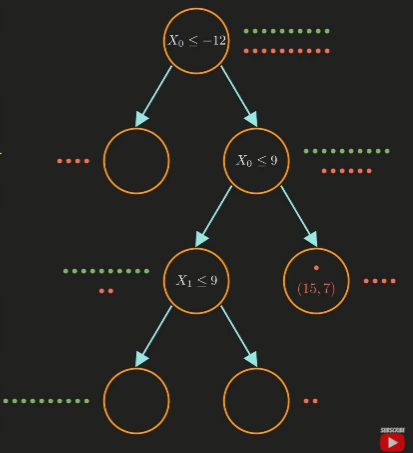

We use `data[idxs]` and `labels[idxs]` represent selected sample index in root node, instead of whole data and labels. So that we can fit in bootstraped sample to train each decision tree, instead of whole training set :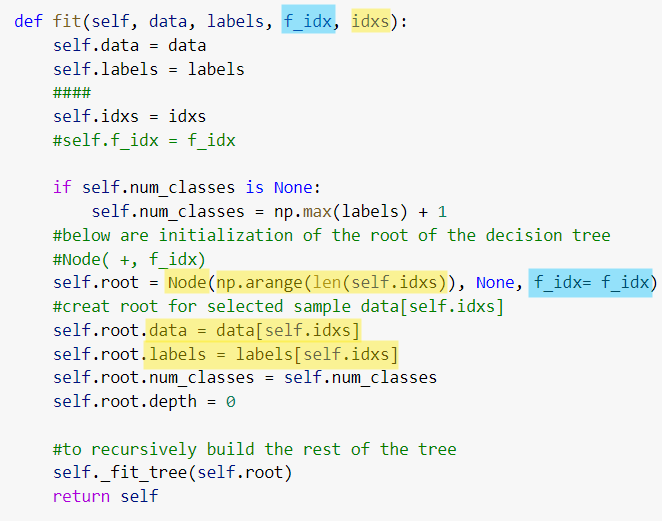


> 2. To split node by compare cost of random selected feature in the node

We add an attribute `self.f_idxs` to store indices of selected features, instead of all features: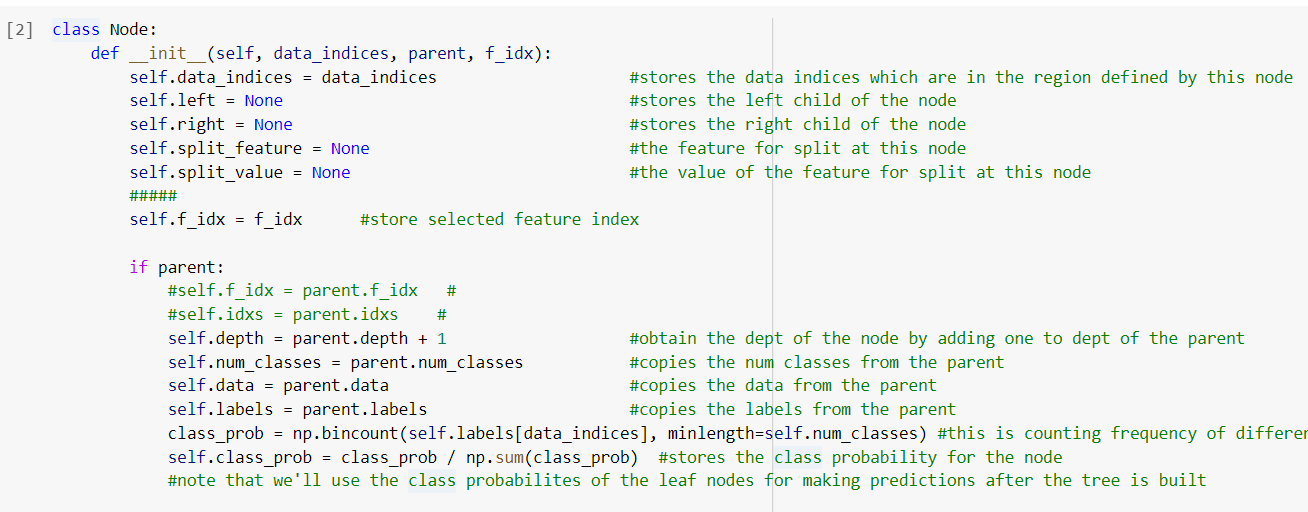

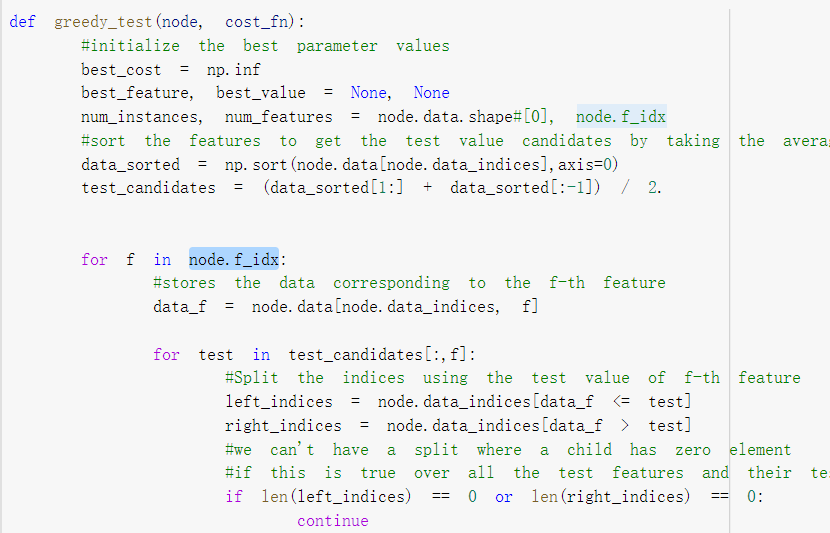





> 3.Instead of all features, Random forest need to renew features randomly for each child nodes from random chosen features and data in root node. Hence create attribute `n_features` to store the number of features which will be drawn and go through each tree, for features bagging.
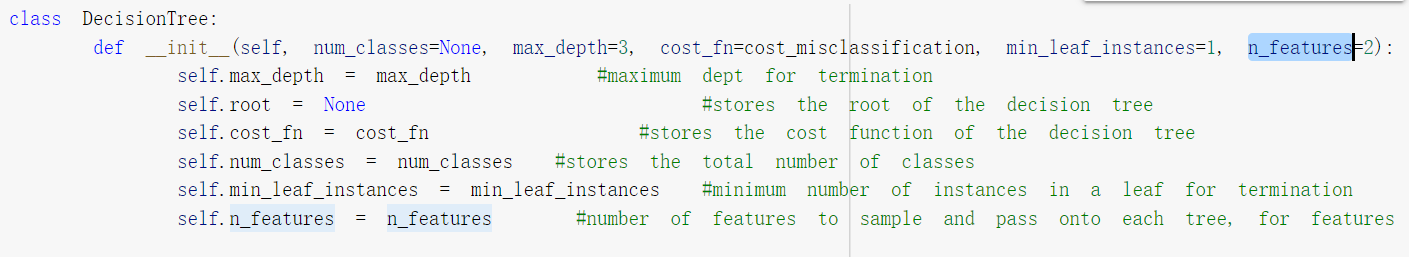

Renew features and split vaulue in child nodes from greedy looped best splitting criteria, randomly select  from `n_features` chosen variables and data in root or parent node of a tree `__fit_tree()` for splitting left node & right node: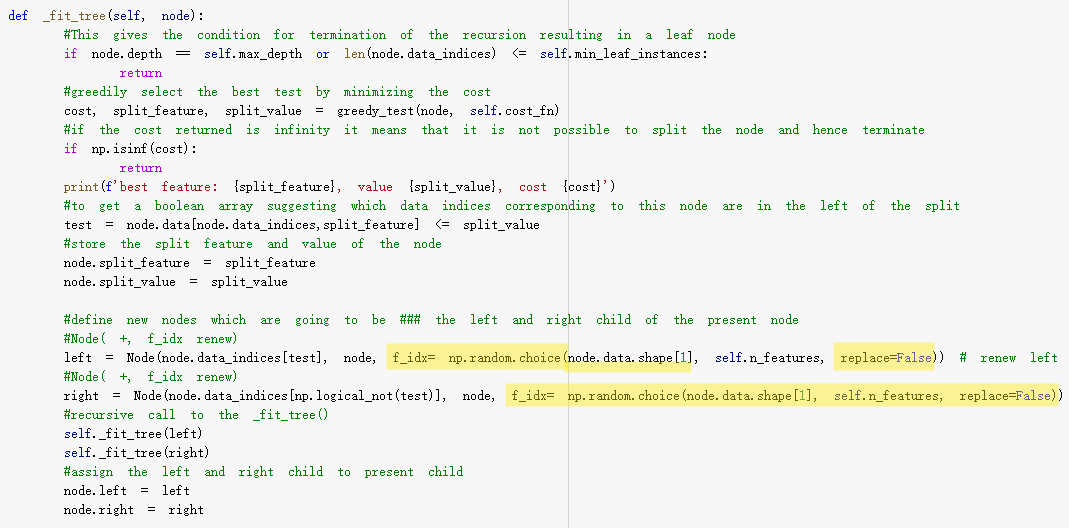

> Finally implement class `RandomForest()`: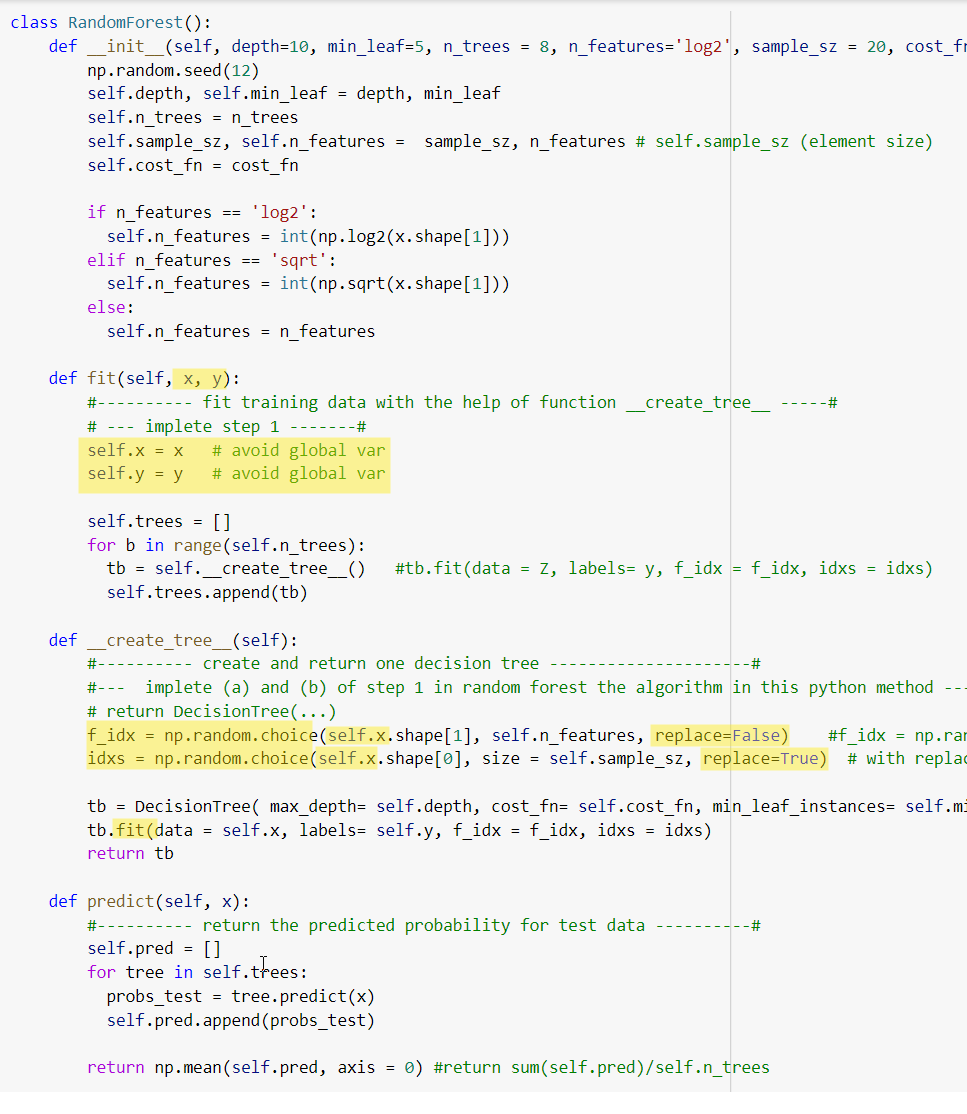

## Part II Implementation of Random forest from scratch.

### 1. Modify the decision tree

**hint: only store the the index of features and samples instead of the whole sampled ```np.array```, Because the index consumes less memory.**


In [ ]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
np.random.seed(1234)

In [ ]:
class Node:
    def __init__(self, data_indices, parent, f_idx):
        self.data_indices = data_indices                    #stores the data indices which are in the region defined by this node
        self.left = None                                    #stores the left child of the node
        self.right = None                                   #stores the right child of the node
        self.split_feature = None                           #the feature for split at this node
        self.split_value = None                             #the value of the feature for split at this node
        #####
        self.f_idx = f_idx      #store selected feature index

        if parent:
            #self.f_idx = parent.f_idx   #
            #self.idxs = parent.idxs    #
            self.depth = parent.depth + 1                   #obtain the dept of the node by adding one to dept of the parent
            self.num_classes = parent.num_classes           #copies the num classes from the parent
            self.data = parent.data                         #copies the data from the parent
            self.labels = parent.labels                     #copies the labels from the parent
            class_prob = np.bincount(self.labels[data_indices], minlength=self.num_classes) #this is counting frequency of different labels in the region defined by this node
            self.class_prob = class_prob / np.sum(class_prob)  #stores the class probability for the node
            #note that we'll use the class probabilites of the leaf nodes for making predictions after the tree is built


In [ ]:
def greedy_test(node, cost_fn):
    #initialize the best parameter values
    best_cost = np.inf
    best_feature, best_value = None, None
    num_instances, num_features = node.data.shape#[0], node.f_idx
    #sort the features to get the test value candidates by taking the average of consecutive sorted feature values
    data_sorted = np.sort(node.data[node.data_indices],axis=0)
    test_candidates = (data_sorted[1:] + data_sorted[:-1]) / 2.


    for f in node.f_idx:
        #stores the data corresponding to the f-th feature
        data_f = node.data[node.data_indices, f]

        for test in test_candidates[:,f]:
            #Split the indices using the test value of f-th feature
            left_indices = node.data_indices[data_f <= test]
            right_indices = node.data_indices[data_f > test]
            #we can't have a split where a child has zero element
            #if this is true over all the test features and their test values  then the function returns the best cost as infinity
            if len(left_indices) == 0 or len(right_indices) == 0:
                continue
            #compute the left and right cost based on the current split
            left_cost = cost_fn(node.labels[left_indices])
            right_cost = cost_fn(node.labels[right_indices])
            num_left, num_right = left_indices.shape[0], right_indices.shape[0]
            #get the combined cost using the weighted sum of left and right cost
            cost = (num_left * left_cost + num_right * right_cost)/num_instances
            #update only when a lower cost is encountered
            if cost < best_cost:
                best_cost = cost
                best_feature = f # num_features[f]
                best_value = test
    return best_cost, best_feature, best_value


In [ ]:
#computes misclassification cost by subtracting the maximum probability of any class
def cost_misclassification(labels):
    counts = np.bincount(labels)
    class_probs = counts / np.sum(counts)
    #you could compress both the steps above by doing class_probs = np.bincount(labels) / len(labels)
    return 1 - np.max(class_probs)

#computes entropy of the labels by computing the class probabilities
def cost_entropy(labels):
    class_probs = np.bincount(labels) / len(labels)
    class_probs = class_probs[class_probs > 0]              #this steps is remove 0 probabilities for removing numerical issues while computing log
    return -np.sum(class_probs * np.log(class_probs))       #expression for entropy -\sigma p(x)log[p(x)]

#computes the gini index cost
def cost_gini_index(labels):
    class_probs = np.bincount(labels) / len(labels)
    return 1 - np.sum(np.square(class_probs))               #expression for gini index 1-\sigma p(x)^2


In [ ]:
class DecisionTree:
    def __init__(self, num_classes=None, max_depth=3, cost_fn=cost_misclassification, min_leaf_instances=1, n_features=2):
        self.max_depth = max_depth      #maximum dept for termination
        self.root = None                #stores the root of the decision tree
        self.cost_fn = cost_fn          #stores the cost function of the decision tree
        self.num_classes = num_classes  #stores the total number of classes
        self.min_leaf_instances = min_leaf_instances  #minimum number of instances in a leaf for termination
        self.n_features = n_features    #number of features to sample and pass onto each tree, for features bagging

    def fit(self, data, labels ):
        pass                            #pass in python 3 means nothing happens and the method here is empty

    def predict(self, data_test):
        pass


def fit(self, data, labels, f_idx, idxs):
    self.data = data
    self.labels = labels
    ####
    self.idxs = idxs
    #self.f_idx = f_idx # renew

    if self.num_classes is None:
        self.num_classes = np.max(labels) + 1
    #below are initialization of the root of the decision tree
    #Node( +, f_idx)
    self.root = Node(np.arange(len(self.idxs)), None, f_idx= f_idx) # Node(np.arange(data.shape[0]), None)
    #creat root for selected sample data[self.idxs]
    self.root.data = data[self.idxs]
    self.root.labels = labels[self.idxs]
    self.root.num_classes = self.num_classes
    self.root.depth = 0

    #to recursively build the rest of the tree
    self._fit_tree(self.root)
    return self

def _fit_tree(self, node):
    #This gives the condition for termination of the recursion resulting in a leaf node
    if node.depth == self.max_depth or len(node.data_indices) <= self.min_leaf_instances:
        return
    #greedily select the best test by minimizing the cost
    cost, split_feature, split_value = greedy_test(node, self.cost_fn)
    #if the cost returned is infinity it means that it is not possible to split the node and hence terminate
    if np.isinf(cost):
        return
    #print(f'best feature: {split_feature}, value {split_value}, cost {cost}')
    #to get a boolean array suggesting which data indices corresponding to this node are in the left of the split
    test = node.data[node.data_indices,split_feature] <= split_value
    #store the split feature and value of the node
    node.split_feature = split_feature
    node.split_value = split_value

    #define new nodes which are going to be ### the left and right child of the present node
    #Node( +, f_idx renew)
    left = Node(node.data_indices[test], node, f_idx= np.random.choice(node.data.shape[1], self.n_features, replace=False)) # renew best features and value for left child node, from selected features and data in root node/ parent node
    #Node( +, f_idx renew)
    right = Node(node.data_indices[np.logical_not(test)], node, f_idx= np.random.choice(node.data.shape[1], self.n_features, replace=False)) # renew best features and value for right child node, from selected features and data in root node/ parent node
    #recursive call to the _fit_tree()
    self._fit_tree(left)
    self._fit_tree(right)
    #assign the left and right child to present child
    node.left = left
    node.right = right

DecisionTree.fit = fit
DecisionTree._fit_tree = _fit_tree
def predict(self, data_test):
    class_probs = np.zeros((data_test.shape[0], self.num_classes))
    for n, x in enumerate(data_test):
        node = self.root
        #loop along the dept of the tree looking region where the present data sample fall in based on the split feature and value
        while node.left:
            if x[node.split_feature] <= node.split_value:
                node = node.left
            else:
                node = node.right
        #the loop terminates when you reach a leaf of the tree and the class probability of that node is taken for prediction
        class_probs[n,:] = node.class_prob
    return class_probs

DecisionTree.predict = predict

### 2. Let's start work on the implementation of random forest.
The skeleton of python class ```randomforest``` is provided. Please, implement the two important python methods, ```fit```, and ```predict```.

Below is the description for the arguements,

We are creating a random forest regressor, although the same code can be slightly modified to create a classifier. To start out, we need to know what our black box takes as input to yield the output (prediction) so we need to know the parameters that define our random forest :
x: independent variables of training set. To keep things minimal and simple I am not creating a separate fit method hence the base class constructor will accept the training set.

- ```x or y```: the random and corresponding dependent variables necessary for supervised learning (Random forest is a supervised learning technique)
- ```n_trees``` : number of uncorrelated trees we ensemble to create the random forest.
- ```n_features```: the number of features to sample and pass onto each tree, this is where feature bagging happens. It can either be ```"sqrt"```, ```"log2"``` or an integer. In case of sqrt, the number of features sampled to each tree is square root of total features and log base 2 of total features in case of log2.

- ```sample_size```: the number of rows randomly selected and passed onto each tree. This is usually equal to total number of rows but can be reduced to increase performance and decrease correlation of trees in some cases (bagging of trees is a completely separate machine learning technique)
depth: depth of each decision tree. Higher depth means more number of splits which increases the over fitting tendency of each tree but since we are aggregating several uncorrelated trees, over fitting of individual trees hardly bothers the whole forest.
- ```min_leaf```: minimum number of samples required in a node to cause further split. Lower the min_leaf, higher the depth of the tree.

- ``` const_fn```: objective function for decision tree.



In [ ]:
class RandomForest():
    def __init__(self, depth=10, min_leaf=5, n_trees = 8, n_features='log2', sample_sz = 20, cost_fn =cost_misclassification):
        np.random.seed(12)
        self.depth, self.min_leaf = depth, min_leaf
        self.n_trees = n_trees
        self.sample_sz, self.n_features =  sample_sz, n_features # self.sample_sz (elements size)
        self.cost_fn = cost_fn

        if n_features == 'log2':
          self.n_features = int(np.log2(x.shape[1]))
        elif n_features == 'sqrt':
          self.n_features = int(np.sqrt(x.shape[1]))
        else:
          self.n_features = n_features

    def fit(self, x, y):
        #---------- fit training data with the help of function __create_tree__ -----#
        # --- implete step 1 -------#
        self.x = x   # avoid global var
        self.y = y   # avoid global var

        self.trees = []
        for b in range(self.n_trees):
          tb = self.__create_tree__()   #tb.fit(data = Z, labels= y, f_idx = f_idx, idxs = idxs)
          self.trees.append(tb)

    def __create_tree__(self):
        #---------- create and return one decision tree ---------------------#
        #---  implete (a) and (b) of step 1 in random forest the algorithm in this python method ---- #
        # return DecisionTree(...)
        f_idx = np.random.choice(self.x.shape[1], self.n_features, replace=False)    #f_idx = np.random.choice(x.shape[1], int(np.log2(x.shape[1])), replace=False)
        idxs = np.random.choice(self.x.shape[0], size = self.sample_sz, replace=True)  # with replacement by self.sample_sz  # Z = x[idxs,:]

        tb = DecisionTree( max_depth= self.depth, cost_fn= self.cost_fn, min_leaf_instances= self.min_leaf, n_features = self.n_features)
        tb.fit(data = self.x, labels= self.y, f_idx = f_idx, idxs = idxs)
        return tb

    def predict(self, x):
        #---------- return the predicted probability for test data ----------#
        self.pred = []
        for tree in self.trees:
          probs_test = tree.predict(x)
          self.pred.append(probs_test)

        return np.mean(self.pred, axis = 0) #return sum(self.pred)/self.n_trees

### Part 3 experiments and visualization.

In this section, you need to use the self-implemented random forest to build classification model for Iris dataset.

(1) We fit the random forest to the training data and predict on the test data. Please also report the test accuracy. [It should be about or higher than 96%]

*Gini index is used as the cost function.*


(2) visualizing the result using scattered plots, with the following elements.
- Only use the first two features as the x and y axis for the 2D visualization.

- Use different shape to represent training data and testing data.

- Use different color to represent different labels.

- Use different shape to mark correct prediction and misclassificaiton for testing samples.

- Include a legend for the above symbols.





In [ ]:
## Load data
from sklearn import datasets
dataset = datasets.load_iris()
x, y = dataset['data'], dataset['target']
(num_instances, num_features), num_classes = x.shape, np.max(y)+1
inds = np.random.permutation(num_instances)
#train-test split)
x_train, y_train = x[inds[:100]], y[inds[:100]]
x_test, y_test = x[inds[100:]], y[inds[100:]]

In [ ]:
#----- (1) we fit the tree to the training data and predict on the test data. ---##
rf = RandomForest(cost_fn = cost_gini_index, n_trees = 15)
rf.fit(x_train, y_train)
probs_test = rf.predict(x_test)

y_pred = np.argmax(probs_test,1)

accuracy = np.sum(y_pred == y_test)/y_test.shape[0]
print(f'accuracy is {accuracy*100:.1f}.')

accuracy is 96.0.


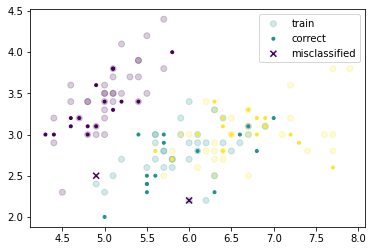

In [ ]:
# ----(2) visualization for results ------------------------------------------
correct = y_test == y_pred
incorrect = np.logical_not(correct)
plt.scatter(x_train[:,0], x_train[:,1], c=y_train, marker='o', alpha=.2, label='train')
plt.scatter(x_test[correct,0], x_test[correct,1], marker='.', c=y_pred[correct], label='correct')
plt.scatter(x_test[incorrect,0], x_test[incorrect,1], marker='x', c=y_test[incorrect], label='misclassified')
plt.legend()
plt.show()